In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
import pickle
from shutil import copyfile
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage.filters import threshold_otsu as otsu
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
from scipy.spatial import distance_matrix
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
def binarize_image(data,scale=1,binarize=True):
    if binarize:
        threshold = otsu(data)*scale
        data_binarized = np.where(data>threshold, 1, 0)
        return data_binarized
    else:
        return data
    
def calc_centroid(binary_image):
    return scipy.ndimage.measurements.center_of_mass(binary_image)

def calc_centroid_alex(binary_image):
    return np.argwhere(binary_image==1).mean(0)
        
def plot_centroid(cx,cy,cz,axis,color='r'):
    if axis==0:
        plt.scatter(cz,cy,color=color)
    elif axis==1:
        plt.scatter(cz,cx,color=color)
    elif axis==2:
        plt.scatter(cy,cx,color=color)
    
def draw_grid(vlines=5, hlines=5, lw=.5):
    for i in np.arange(0,vlines*20,20):
        plt.axvline(i,color='w',lw=lw)
    for i in np.arange(0,hlines*20,20):
        plt.axhline(i,color='w',lw=lw)
        
def clean_anat(brain):
    brain_copy = brain.copy().astype('float32')
    brain_copy = scipy.ndimage.filters.gaussian_filter(brain_copy, sigma=0.5)

    labels, label_nb = scipy.ndimage.label(brain_copy)
    brain_label = np.bincount(labels.flatten())[1:].argmax()+1

    brain_copy = np.where(labels==brain_label, 1.0, 0.0)

    return brain_copy*brain

def upper_tri_indexing(A):
    m = A.shape[0]
    r,c = np.triu_indices(m,1)
    return A[r,c]

In [3]:
working_dir = '/oak/stanford/groups/trc/data/Alex/clab_data/DSX/func/aligned_to_FDA/'
#working_dir = '/oak/stanford/groups/trc/data/Alex/clab_data/DSX/func/synthmorph_to_FDA_luke_pipeline/'
import glob
fly_files = glob.glob(os.path.join(working_dir, ('*.nii')))

In [186]:
fly_files[6]

'/oak/stanford/groups/trc/data/Alex/clab_data/DSX/func/aligned_to_FDA/201113_02_green_registered.nii'

In [70]:
file = '/oak/stanford/groups/trc/data/Alex/clab_data/DSX/func/aligned_to_FDA/201113_02_green_registered.nii'
func = ants.image_read(file)

file = '/oak/stanford/groups/trc/data/Alex/clab_data/DSX/anat/registered/201113_02_red_registered.nii'
anat = ants.image_read(file)

In [71]:
func.shape, anat.shape

((826, 384, 240), (1024, 512, 256))

In [72]:
anat.set_spacing((1,1,1))
anat = ants.resample_image(anat,(826,384,240),1,0)

In [123]:
cmap = LinearSegmentedColormap.from_list('mycmap', ['k', 'cyan'])
temp = np.max(func[:,:,70:105],axis=2).T
out = cmap(NormalizeData(temp))
ids = np.where(temp<700)#250)
out[ids[0],ids[1],3] = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


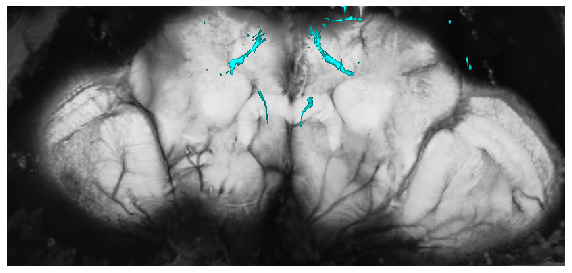

In [130]:
plt.figure(figsize=(10,10))

plt.imshow(anat[:,:,55:105].max(-1).T,cmap='Greys_r',vmax=1.2)
plt.imshow(out*3)
plt.axis('off')
# plt.axvline(330)
# plt.axvline(380)
# plt.axhline(50)
# plt.axhline(90)
#plt.xlim(330,380)
#plt.ylim(90,50)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [131]:
.219*(1/.76)

0.2881578947368421

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(np.max(anat[:,:,80:140],axis=2).T,cmap='Greys_r')
#plt.imshow(np.max(func[:,:,70:130],axis=2).T,cmap=cmap)#,vmax=2500)

plt.imshow(out*2.6)#,vmax=8000)
# plt.xlim(270,370)
# plt.ylim(310,210)

In [11]:
bbox = {'x_start': 330, 'x_end': 380,
        'y_start': 50, 'y_end': 90,
        'z_start': 65, 'z_end': 95}

In [227]:
#slightly smaller on DV axis for better connectome figure
bbox = {'x_start': 330, 'x_end': 380,
        'y_start': 60, 'y_end': 90,
        'z_start': 65, 'z_end': 95}

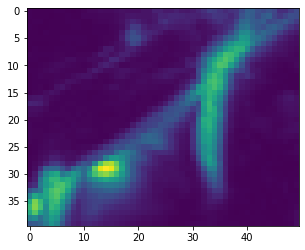

In [85]:
cropped_image = test_img[bbox['x_start']:bbox['x_end'],
                   bbox['y_start']:bbox['y_end'],
                   bbox['z_start']:bbox['z_end']]

plt.imshow(cropped_image.max(-1).T)
#plt.imshow(brain_cropped[0].mean(-1).T)

In [228]:
### Luke's bigger box
# bbox = {'x_start': 310, 'x_end': 400,
#         'y_start': 30, 'y_end': 110,
#         'z_start': 55, 'z_end': 105}

brain_cropped = []
for fly in fly_files:
    print(fly.split('/')[-1])
    DSX_fda = ants.image_read(fly)
    #DSX_fda = DSX_fda[::-1, :, :] # for right brain
    DSX_fda_cropped = DSX_fda[bbox['x_start']:bbox['x_end'],
                           bbox['y_start']:bbox['y_end'],
                           bbox['z_start']:bbox['z_end']]
    brain_cropped.append(DSX_fda_cropped)

201113_03_green_registered.nii
201113_01_green_registered.nii
201206_02_green_registered.nii
210128_04_green_registered.nii
210128_02_green_registered.nii
201106_03_green_registered.nii
201113_02_green_registered.nii
201113_04_green_registered.nii
201106_02_green_registered.nii
201204_03_green_registered.nii


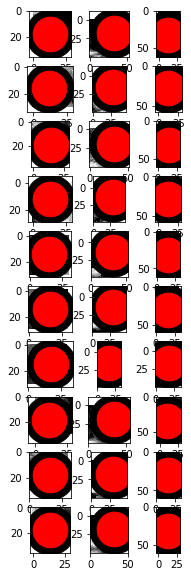

In [230]:
plt.figure(figsize=(3,12))

#scales = [0.4, 0.6, 0.6, 0.2, 0.6, 0.7, 0.7, 0.3, 0.6, 0.9] # for right brain
scales = [0.3, 0.5, 0.3, 0.4, 0.5, 0.8, 0.5, 0.3, 0.4, 0.7] # for left brain
for i in range(len(brain_cropped)):
    for axis in [0,1,2]:
        plt.subplot(12,3,(3*i+axis)+1)
        cropped_image_binary = binarize_image(brain_cropped[i], scale=scales[i])
        plt.imshow(np.mean(cropped_image_binary,axis=axis),cmap='Greys_r')
        cx,cy,cz = calc_centroid(cropped_image_binary)
        plot_centroid(cx,cy,cz,axis,color='r')
        #draw_grid()
        #plt.axis('off')
#plt.subplots_adjust(wspace=-.1,hspace=0)

In [231]:
#flies_to_remove = ['201113_03_green_registered.nii', '201113_04_green_registered.nii']
del brain_cropped[7]
del brain_cropped[0]
del scales[7]
del scales[0]

In [203]:
brain_cropped_clandinin = brain_cropped.copy()

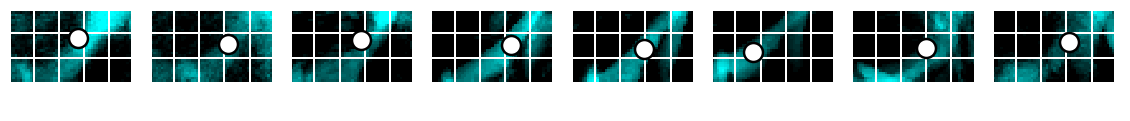

In [232]:
def plot_centroid(cx,cy,cz,axis,color='r',transpose=False):
    if axis==0:
        plt.scatter(cz,cy,color='k',linewidth=1.5)
        plt.scatter(cz,cy,color=color,linewidth=.5)
    elif axis==1:
        plt.scatter(cz,cx,color='k',linewidth=15.5)
        plt.scatter(cz,cx,color=color,linewidth=10.5)
    elif axis==2:
        if transpose:
            plt.scatter(cx,cy,color='k',linewidth=15.5,zorder=10)
            plt.scatter(cx,cy,color=color,linewidth=10.5,zorder=10)
        else:
            plt.scatter(cy,cx,color='k',linewidth=15.5,zorder=10)
            plt.scatter(cy,cx,color=color,linewidth=10.5,zorder=10)

def draw_grid(vlines=5, hlines=4, lw=.5):
    step = 10
    for i in np.arange(0,vlines*step,step):
        plt.axvline(i,color='w',lw=lw)
    for i in np.arange(0,hlines*step,step):
        plt.axhline(i,color='w',lw=lw)
            
########################################
### visually confirm good thresholds ###
########################################

plt.figure(figsize=(20,10))
centroids_clandinin = []
for i in range(8):#range(len(brains_cropped[brain_type])):
    axis=2
    plt.subplot(1,8,i+1)
    cropped_image_binary = binarize_image(brain_cropped[i], scale=scales[i])

    cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'cyan'])
    
    plt.imshow(np.mean(cropped_image_binary,axis=axis).T,cmap=cmap)
    draw_grid(lw=2)
    plt.axvline(0,color='w',lw=6)
    plt.axhline(0,color='w',lw=6)
    plt.axvline(50,color='w',lw=6)
    plt.axhline(40,color='w',lw=6)
    plt.axis('off')
    
    cx,cy,cz = calc_centroid(cropped_image_binary)
    centroids_clandinin.append((cx,cy,cz))
    #plot_centroid(cx,cy,cz,axis,color='w')
    plot_centroid(cx,cy,cz,axis,color='w',transpose=True)
    #plt.xlim(0,50)
    #plt.ylim(40,0)
    
    
plt.subplots_adjust(wspace=0.05)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [52]:
os.listdir("/oak/stanford/groups/trc/data/Alex/clab_data/DSX/")

['DSX_flywire_transformed_FDA_physical.npy',
 'DSX_skeleton_flywire_FDA.nii',
 'pCd1_skeleton_flywire_FDA_ds_flip.nii',
 'func',
 'DSX_skeleton_flywire_FDA_ds_flip.nii',
 'anat']

In [35]:
file = "/oak/stanford/groups/trc/data/Alex/clab_data/DSX/pCd1_skeleton_flywire_FDA_ds_flip.nii"
#file = "/oak/stanford/groups/trc/data/Alex/clab_data/DSX/DSX_skeleton_flywire_FDA_ds_flip.nii"
DSX_connectome = ants.image_read(file).numpy()

In [36]:
DSX_connectome.shape

(826, 384, 240)

(-0.5, 825.5, 383.5, -0.5)

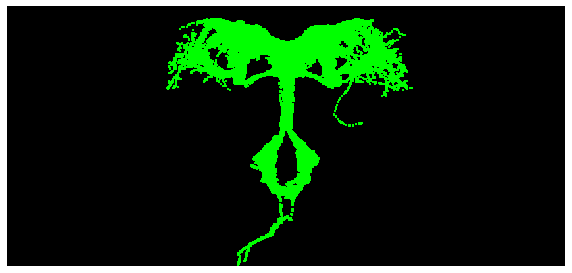

In [37]:
cmap = LinearSegmentedColormap.from_list('mycmap', ['black', (0,1,0)])
plt.figure(figsize=(10,10))
plt.imshow(np.max(DSX_connectome,axis=2).T,cmap=cmap)
plt.axis('off')

In [215]:
DSX_connectome_cropped = DSX_connectome[bbox['x_start']:bbox['x_end'],
                   bbox['y_start']:bbox['y_end'],
                   bbox['z_start']:bbox['z_end']]

In [234]:
DSX_connectome_cropped.shape

(50, 30, 30)

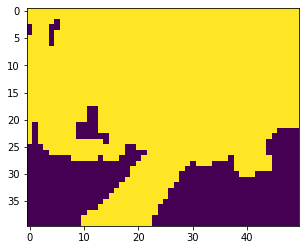

In [47]:
plt.imshow(np.max(DSX_connectome_cropped,axis=2).T)

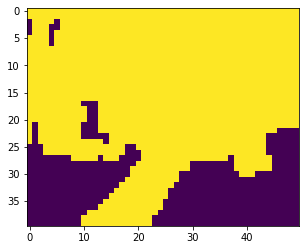

In [28]:
plt.imshow(np.max(DSX_connectome_cropped,axis=2).T)

In [236]:
brain_cropped_clandinin[0].shape

(50, 40, 20)

In [237]:
meanbrain = np.zeros(brain_cropped[0].shape)
for i in range(len(brain_cropped)):
    max_value = np.max(brain_cropped[i])
    if max_value == 0:
        max_value = 1            
    meanbrain += brain_cropped[i]/max_value
meanbrains_cropped_clandinin = meanbrain.copy()

In [238]:
meanbrains_cropped_clandinin.shape

(50, 30, 30)

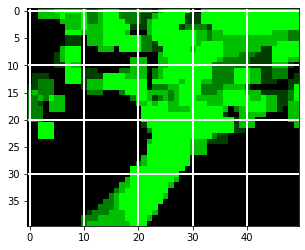

In [145]:
draw_grid(lw=2)
cmap = LinearSegmentedColormap.from_list('mycmap', ['black', (0,1,0)])
plt.imshow(np.mean(DSX_connectome_cropped[:,:,15:20],axis=2).T,cmap=cmap,vmax=.8)

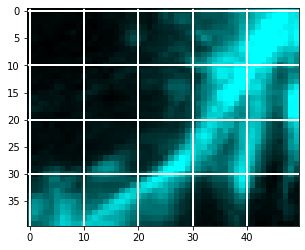

In [139]:
draw_grid(lw=2)
cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'cyan'])
plt.imshow(np.max(meanbrains_cropped_clandinin,axis=2).T,cmap=cmap,vmax=2)

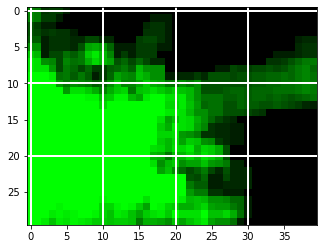

In [152]:
draw_grid(lw=2)
cmap = LinearSegmentedColormap.from_list('mycmap', ['black', (0,1,0)])
plt.imshow(np.mean(DSX_connectome_cropped[:,:,:],axis=0).T[::-1,:],cmap=cmap,vmax=.5)

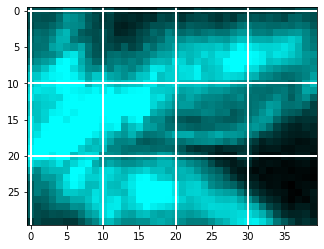

In [157]:
draw_grid(lw=2)
cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'cyan'])
plt.imshow(np.max(meanbrains_cropped_clandinin[15:50,:,:],axis=0).T[::-1,:],cmap=cmap,vmax=2)



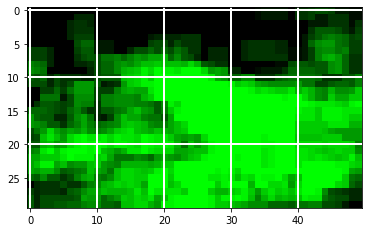

In [158]:
draw_grid(lw=2)
cmap = LinearSegmentedColormap.from_list('mycmap', ['black', (0,1,0)])
plt.imshow(np.mean(DSX_connectome_cropped[:,:,:],axis=1).T[::-1,:],cmap=cmap,vmax=.5)

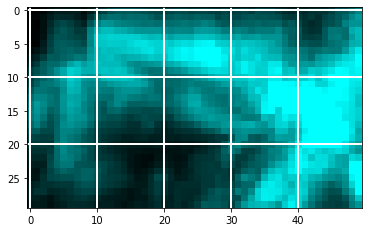

In [159]:
draw_grid(lw=2)
cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'cyan'])
plt.imshow(np.max(meanbrains_cropped_clandinin[:,:,:],axis=1).T[::-1,:],cmap=cmap,vmax=2)



In [86]:
meanbrains_cropped_clandinin.shape

(50, 40, 30)

# murthy

In [11]:
working_dir = '/oak/stanford/groups/trc/data/Alex/albert_data/DSX/func/synthmorph_to_FDA/'
#working_dir = '/oak/stanford/groups/trc/data/Alex/albert_data/DSX/func/synthmorph_to_FDA_luke_pipeline/'
import glob
fly_files = glob.glob(os.path.join(working_dir, ('2*.nii')))

In [257]:
fly_files

['/oak/stanford/groups/trc/data/Alex/albert_data/DSX/func/synthmorph_to_FDA/220605_dsx_vol3_fda.nii',
 '/oak/stanford/groups/trc/data/Alex/albert_data/DSX/func/synthmorph_to_FDA/220408_dsx_vol1_fda.nii',
 '/oak/stanford/groups/trc/data/Alex/albert_data/DSX/func/synthmorph_to_FDA/220605_dsx_vol2_fda.nii']

In [ ]:
220605_dsx_vol3

In [444]:
os.listdir('/oak/stanford/groups/trc/data/Alex/albert_data/DSX/anat/registered')

['220408_dsx_vol1_local_atlas_red_registered.nii',
 '221108_dsx_vol1_local_atlas_red_registered.nii',
 '220616_dsx_vol2_local_atlas_red_registered.nii',
 '220422_dsx_vol1_local_atlas_red_registered.nii',
 '220616_dsx_vol1_local_atlas_red_registered.nii',
 '220604_dsx_vol1_local_atlas_red_registered.nii',
 '220605_dsx_vol3_local_atlas_red_registered.nii',
 '220605_dsx_vol2_local_atlas_red_registered.nii']

In [445]:
file = '/oak/stanford/groups/trc/data/Alex/albert_data/DSX/anat/registered/220605_dsx_vol3_local_atlas_red_registered.nii'
brain = ants.image_read(file)

In [ ]:
file = '/oak/stanford/groups/trc/data/Alex/albert_data/DSX/anat/registered/220605_dsx_vol3_local_atlas_red_registered.nii'
brain = ants.image_read(file)

In [439]:
file = '/oak/stanford/groups/trc/data/Alex/albert_data/DSX/anat/raw2/220605_dsx_vol3_local_atlas_red.nii'
#anat = ants.image_read(file)

file = '/oak/stanford/groups/trc/data/Alex/albert_data/DSX/func/synthmorph_to_FDA/220605_dsx_vol3_fda.nii'
func = ants.image_read(file)

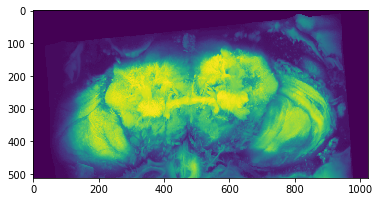

In [449]:
plt.imshow(np.max(brain.numpy(),axis=2).T,vmax=1,vmin=0)

In [416]:
file = '/oak/stanford/groups/trc/data/Alex/albert_data/DSX/anat/raw2/220605_dsx_vol3_local_atlas_red.nii'
anat = ants.image_read(file)

file = '/oak/stanford/groups/trc/data/Alex/albert_data/DSX/func/raw/220605_dsx_vol3_local_atlas_green.nii'
func = ants.image_read(file)

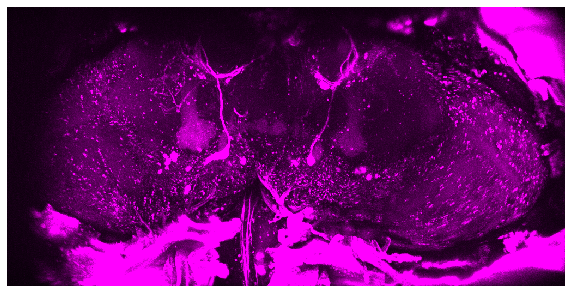

In [417]:
cmap = LinearSegmentedColormap.from_list('mycmap', ['k', 'magenta'])

plt.figure(figsize=(10,10))
plt.imshow(np.max(func.numpy()[:,:,40:-100],axis=2).T,vmin=0,vmax=500,cmap=cmap)
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

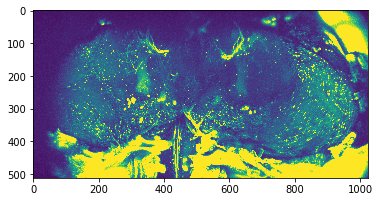

In [423]:
plt.imshow(temp,vmin=0,vmax=500)

In [435]:
cmap = LinearSegmentedColormap.from_list('mycmap', ['k', 'magenta'])
temp = np.max(func[:,:,40:-100],axis=2).T
out = cmap(NormalizeData(temp))
ids = np.where(temp<150)
out[ids[0],ids[1],3] = 0
out = np.asarray(out)

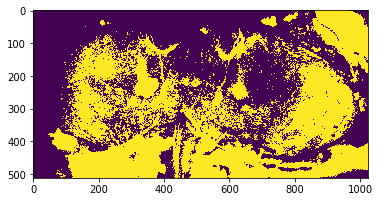

In [436]:
plt.imshow(out[:,:,3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


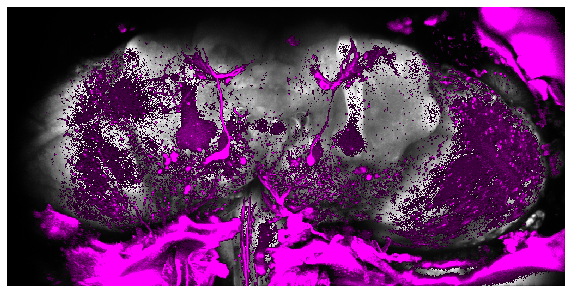

In [438]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(anat.numpy()[:,:,50:],axis=2).T,vmin=0,vmax=8000,cmap='Greys_r')
plt.imshow(out*30)
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [259]:
#file = '/oak/stanford/groups/trc/data/Alex/albert_data/DSX/func/synthmorph_to_FDA/220605_dsx_vol3_fda.nii'
file = '/oak/stanford/groups/trc/data/Alex/albert_data/DSX/anat/registered/220605_dsx_vol3_local_atlas_red_registered.nii'

test_img = ants.image_read(file)

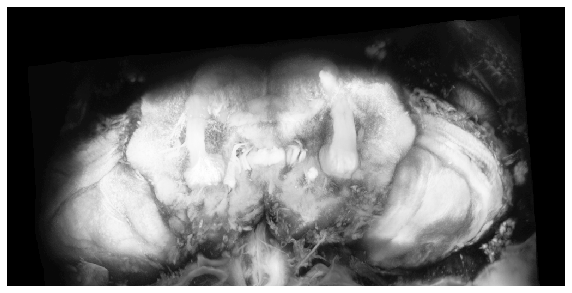

In [260]:
cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'magenta'])

plt.figure(figsize=(10,10))

plt.imshow(test_img[:,:,50:-50].max(-1).T,cmap='Greys_r',vmax=1)
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [94]:
brain_cropped = []
for fly in fly_files:
    print(fly.split('/')[-1])
    DSX_fda = ants.image_read(fly)
    #DSX_fda = DSX_fda[::-1, :, :]
    DSX_fda_cropped = DSX_fda[bbox['x_start']:bbox['x_end'],
                           bbox['y_start']:bbox['y_end'],
                           bbox['z_start']:bbox['z_end']]
    brain_cropped.append(DSX_fda_cropped)

220605_dsx_vol3_fda.nii
220408_dsx_vol1_fda.nii
220605_dsx_vol2_fda.nii


In [95]:
brain_cropped_murthy = brain_cropped.copy()

46.70088178561587 34.215348580876274 16.024386883438964
46.70088178561587 34.215348580876274 16.024386883438964
46.70088178561587 34.215348580876274 16.024386883438964
46.06446625553722 44.437545962535104 17.63442485306465
46.06446625553722 44.437545962535104 17.63442485306465
46.06446625553722 44.437545962535104 17.63442485306465
40.576678923586336 40.58074931855185 12.062766405063755
40.576678923586336 40.58074931855185 12.062766405063755
40.576678923586336 40.58074931855185 12.062766405063755


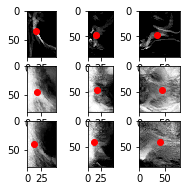

In [25]:
plt.figure(figsize=(3,12))
centroids_murthy = []
scales = [0.8, .4, 0.5] # for left brain
for i in range(3):
    for axis in [0,1,2]:
        plt.subplot(12,3,(3*i+axis)+1)
        cropped_image_binary = binarize_image(brain_cropped[i], scale=scales[i])
        plt.imshow(np.mean(cropped_image_binary,axis=axis),cmap='Greys_r')
        #draw_grid()
        #plt.axis('off')
        #cx,cy,cz = calc_centroid(brain_cropped[i])
        cx,cy,cz = calc_centroid(cropped_image_binary)
        plot_centroid(cx,cy,cz,axis)
        print(cx,cy,cz)
    centroids_murthy.append((cx,cy,cz))

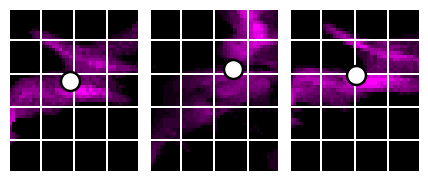

In [165]:
def plot_centroid(cx,cy,cz,axis,color='r',transpose=False):
    if axis==0:
        plt.scatter(cz,cy,color='k',linewidth=1.5)
        plt.scatter(cz,cy,color=color,linewidth=.5)
    elif axis==1:
        plt.scatter(cz,cx,color='k',linewidth=15.5)
        plt.scatter(cz,cx,color=color,linewidth=10.5)
    elif axis==2:
        if transpose:
            plt.scatter(cx,cy,color='k',linewidth=1.5)
            plt.scatter(cx,cy,color=color,linewidth=.5)
        else:
            plt.scatter(cy,cx,color='k',linewidth=15.5,zorder=10)
            plt.scatter(cy,cx,color=color,linewidth=10.5,zorder=10)

def draw_grid(vlines=4, hlines=5, lw=.5):
    step = 10
    for i in np.arange(0,vlines*step,step):
        plt.axvline(i,color='w',lw=lw)
    for i in np.arange(0,hlines*step,step):
        plt.axhline(i,color='w',lw=lw)
            
########################################
### visually confirm good thresholds ###
########################################

plt.figure(figsize=(20,10))
for i in range(3):#range(len(brains_cropped[brain_type])):
    axis=2
    plt.subplot(1,8,i+1)
    cropped_image_binary = binarize_image(brain_cropped[i], scale=scales[i])

    cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'magenta'])
    
    plt.imshow(np.mean(cropped_image_binary,axis=axis),cmap=cmap)
    draw_grid(lw=2)
    plt.axvline(0,color='w',lw=6)
    plt.axhline(0,color='w',lw=6)
    plt.axvline(40,color='w',lw=6)
    plt.axhline(50,color='w',lw=6)
    plt.axis('off')
    
    cx,cy,cz = calc_centroid(cropped_image_binary)
    #plot_centroid(cx,cy,cz,axis,color='w')
    plot_centroid(cx,cy,cz,axis,color='w')
    plt.xlim(0,40)
    plt.ylim(50,0)
    
plt.subplots_adjust(wspace=0.05)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [163]:
cropped_image_binary.shape

(50, 40, 30)

In [223]:
### CLANDININ ###
meanbrain = np.zeros(brain_cropped_clandinin[0].shape)
for i in range(len(brain_cropped_clandinin)):
    max_value = np.max(brain_cropped_clandinin[i])
    if max_value == 0:
        max_value = 1            
    meanbrain += brain_cropped_clandinin[i]/max_value
meanbrains_cropped_clandinin = meanbrain.copy()

### MURTHY ###
# meanbrain = np.zeros(brain_cropped_murthy[0].shape)
# for i in range(len(brain_cropped_murthy)):
#     max_value = np.max(brain_cropped_murthy[i])
#     if max_value == 0:
#         max_value = 1            
#     meanbrain += brain_cropped_murthy[i]/max_value
# meanbrains_cropped_murthy = meanbrain.copy()

In [60]:
meanbrains_cropped_clandinin.shape

(50, 40, 30)

In [219]:
centroids_connectome = []
cx,cy,cz = calc_centroid(DSX_connectome_cropped)
centroids_connectome.append((cx,cy,cz))

In [239]:
DSX_connectome_cropped.shape, meanbrains_cropped_clandinin.shape

((50, 30, 30), (50, 30, 30))

In [255]:
### OG USE THIS ###

def make_overlay(axis):
    image1 = meanbrains_cropped_clandinin
    image2 = DSX_connectome_cropped

    image1 = np.max(image1,axis=axis)
    image2 = np.mean(image2,axis=axis) #MEAN for connectome

    image1 = NormalizeData(image1)
    image2 = NormalizeData(image2)

    cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'cyan'])
    rgba1 = cmap(image1)
    cmap = LinearSegmentedColormap.from_list('mycmap', ['black', (0,1,0)])
    rgba2 = cmap(image2)

    #merge = (rgba1*2)#+(rgba2*2)
    merge = rgba2*2
    merge = NormalizeData(merge)*1.5
    return merge

def plot_centroid(cx,cy,cz,axis,color='r',transpose=False):
    s1 = 2400; s2 = 1200
    if axis==0:
        plt.scatter(cy,30-cz,color='k',s=s1)
        plt.scatter(cy,30-cz,color=color,s=s2)
    elif axis==1:
        plt.scatter(cx,30-cz,color='k',s=s1)
        plt.scatter(cx,30-cz,color=color,s=s2)
    elif axis==2:
        if transpose:
            plt.scatter(cx,cy,color='k',s=s1)
            plt.scatter(cx,cy,color=color,s=s2)
        else:
            plt.scatter(cy,cx,color='k',s=s1)
            plt.scatter(cy,cx,color=color,s=s2)

def plot_all_centroids(axis,transpose=False):
#     for i in range(len(centroids_clandinin)):
#         cx,cy,cz = centroids_clandinin[i]
#         plot_centroid(cx,cy,cz,axis,color='cyan',transpose=transpose)
    for i in range(len(centroids_connectome)):
        cx,cy,cz = centroids_connectome[i]
        plot_centroid(cx,cy,cz,axis,color=(0,1,0),transpose=transpose)
        
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


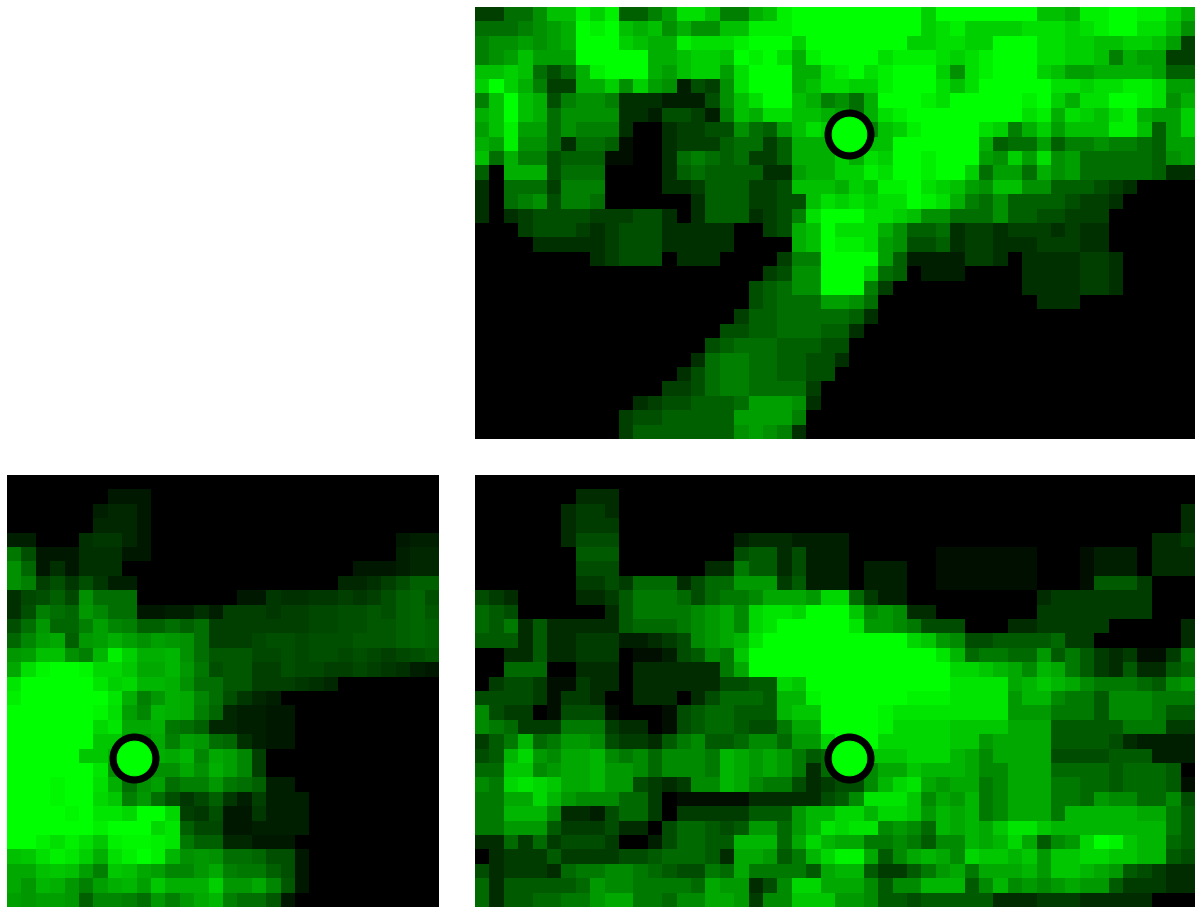

In [257]:
fig = plt.figure(figsize=(10,10))

### BOTTOM LEFT ###
fig.add_axes([-.65,.2,.6,.6])
axis = 0
merge = make_overlay(axis)
plt.imshow(np.swapaxes(merge,0,1)[::-1])
plot_all_centroids(axis)
plt.axis('off')

### TOP RIGHT ###
fig.add_axes([0,.65,1,1])
axis = 2
merge = make_overlay(axis)
plt.imshow(np.swapaxes(merge,0,1))
plot_all_centroids(axis,transpose=True)
plt.axis('off')

### BOTTOM RIGHT ###
fig.add_axes([0,0,1,1])
axis = 1
merge = make_overlay(axis)
plt.imshow(np.swapaxes(merge,0,1)[::-1])
plot_all_centroids(axis)
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [161]:
.164*(1/.76)

0.21578947368421056

# barplot

In [456]:
centroids

{'localmean_synthmorph': {'clandinin': [(35.14012622336047,
    12.398518247507546,
    14.110948504527578),
   (32.39956359102244, 18.989027431421448, 10.990461346633417),
   (31.98286243631311, 15.147753589624827, 16.771730739539912),
   (33.752543562156475, 22.487077534791254, 15.986551280551982),
   (32.37816735415439, 22.134796700058928, 14.493370654095463),
   (21.940782122905027, 21.879748603351956, 13.691061452513967),
   (33.20861810301717, 19.000500083347223, 12.49191531921987),
   (32.93153443415223, 17.75271848570278, 12.067498993153443)],
  'murthy': [(22.24115892628888, 18.705581593523647, 7.576054537707712),
   (18.558686487685822, 25.533392500554694, 6.165520301752829),
   (20.481857764876633, 20.481494920174164, 8.165094339622641)]}}

In [5]:
a = {'localmean_synthmorph': {'clandinin': [(35.14012622336047,12.398518247507546,14.110948504527578),
   (32.39956359102244, 18.989027431421448, 10.990461346633417),
   (31.98286243631311, 15.147753589624827, 16.771730739539912),
   (33.752543562156475, 22.487077534791254, 15.986551280551982),
   (32.37816735415439, 22.134796700058928, 14.493370654095463),
   (21.940782122905027, 21.879748603351956, 13.691061452513967),
   (33.20861810301717, 19.000500083347223, 12.49191531921987),
   (32.93153443415223, 17.75271848570278, 12.067498993153443)]}}

In [242]:
centroids = {'localmean_synthmorph': {}}
centroids['localmean_synthmorph']['clandinin'] = centroids_clandinin
#centroids['localmean_synthmorph']['murthy'] = centroids_murthy
centroids['localmean_synthmorph']['connectome'] = centroids_connectome

In [243]:
comparison_means_all = {}
comparison_std_all = {}
comparison_pairwise_diffs_all = {}

warp_types = ['localmean_synthmorph'] # remove this if comparing across types

for warp_type in warp_types:

    comparisons = [('clandinin', 'connectome')]#,
#                    ('murthy', 'murthy'),
#                    ('clandinin', 'murthy')]

    comparison_means = {}
    comparison_std = {}
    comparison_pairwise_diffs = {}
    
    for comparison in comparisons:
        
        brain_type_1 = comparison[0]
        brain_type_2 = comparison[1]

        pairwise_diffs = []
        
        for axis in [0,1,2]:
            
            a=[i[axis] for i in centroids[warp_type][brain_type_1]]
            b=[i[axis] for i in centroids[warp_type][brain_type_2]]

            ### if it is an intra comparison, skip comparisons of exact same brains
            if brain_type_1 == brain_type_2:
                pairwise_diff = [np.abs((x-y)*.76) for i,x in enumerate(a) for j,y in enumerate(a) if i != j]
            else:
                pairwise_diff = [np.abs((x-y)*.76) for x in a for y in b]
            pairwise_diffs.append(pairwise_diff)

        ### calculate distances given all 3 axes
        distances = (np.asarray(pairwise_diffs[0])**2 +
                     np.asarray(pairwise_diffs[1])**2 + 
                     np.asarray(pairwise_diffs[2])**2)**0.5

        comparison_means[comparison] = np.mean(distances)
        comparison_std[comparison] = np.std(distances)
        comparison_pairwise_diffs[comparison] = distances
        
    comparison_means_all[warp_type] = comparison_means
    comparison_std_all[warp_type] = comparison_std
    comparison_pairwise_diffs_all[warp_type] = comparison_pairwise_diffs

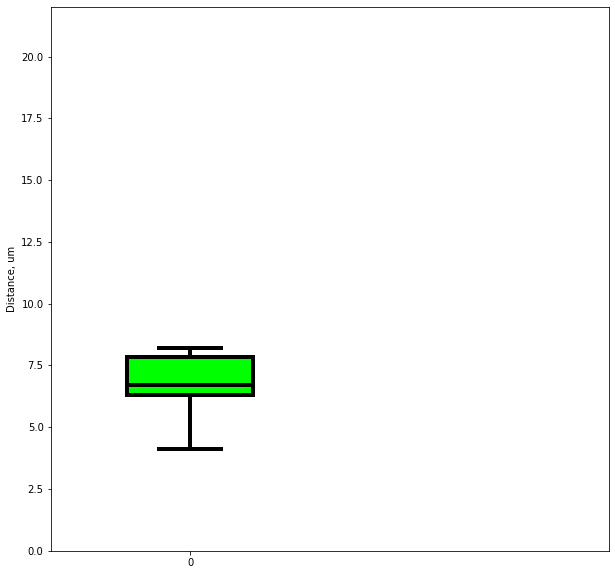

In [258]:
plt.figure(figsize=(10,10))
ax = plt.gca()
bar_width = 0.2
xs_ = [0,.2,.4]
colors = [(0,1,0), 'magenta', 'grey']

comp_to_plot = comparisons
warp_type = 'localmean_synthmorph'

for j,comparsion in enumerate(comp_to_plot):

    bplot = ax.boxplot(comparison_pairwise_diffs_all[warp_type][comparsion],positions=[xs_[j]],
                       showfliers=False,widths=.18,notch=False,patch_artist=True,
       medianprops={"linewidth": 4,"solid_capstyle": "butt","color":'k'},
       boxprops={"linewidth": 4,"color":'k'},
       capprops={"linewidth": 4,"color":'k'},
       whiskerprops={"linewidth": 4,"color":'k'})
    bplot['boxes'][0].set_facecolor(colors[j])

plt.ylabel('Distance, um')
plt.xlim(-.2,.6)
plt.ylim(0,22)
#plt.xticks([.3,1.3,2.3], ['Within-Lab, Clandinin', 'Within-Lab, Murthy', 'Across Lab'])

# ax = plt.gca()
# all_handles = []
# for i in range(len(colors)):
#     all_handles.append(mpatches.Patch(color=colors[i], label=labels[i]))
# leg = ax.legend(handles=all_handles)
# ax.add_artist(leg)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

# FDA views

In [137]:
file = "/oak/stanford/groups/trc/data/Yukun/registration/mean_brain/FDA_downsampled_flip.nii"
FDA = ants.image_read(file)

In [138]:
FDA

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (826, 384, 240)
	 Spacing    : (0.76, 0.76, 0.76)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

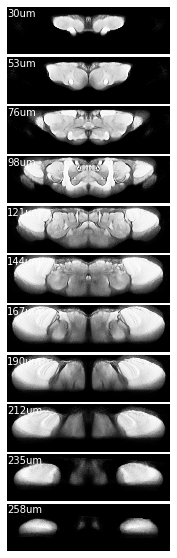

In [182]:
plt.figure(figsize=(10,10))
slices = list(range(40,200,30)) #Z
#slices = list(range(150,700,70)) #X
slices = list(range(40,350,30)) #Y


for k,i in enumerate(slices):
    plt.subplot(len(slices),1,k+1)
    plt.imshow(FDA[:,i,:].T,cmap='Greys_r')
    plt.axis('off')
    plt.text(x=0,y=50,s=str(int(i*.76))+'um',color='w')
plt.subplots_adjust(hspace=.05)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [183]:
FDA

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (826, 384, 240)
	 Spacing    : (0.76, 0.76, 0.76)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [184]:
826*.76

627.76

In [186]:
2.8*(100/628)

0.4458598726114649

In [187]:
.7*(50/(240*.76))

0.19188596491228066

In [188]:
384*.76

291.84000000000003